In [12]:
import torch
from torch import nn
from torch.nn import functional as F
from torchviz import make_dot

device = torch.device(device='cuda' if torch.cuda.is_available() else 'cpu')
print('torch version is', torch.__version__)
print('device is', device)

torch version is 2.0.0
device is cuda


# 1.层和块

## 1.1 自定义块

In [13]:
class MLP(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(in_features=20, out_features=256)
        self.out = nn.Linear(in_features=256, out_features=10)
        
    def forward(self, X):
        return self.out(F.relu(input=self.hidden(X)))

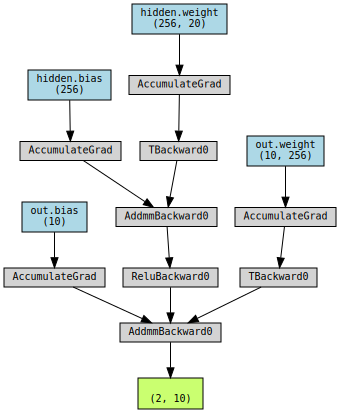

In [14]:
X = torch.rand(2, 20)
net = MLP()
y = net(X)
make_dot(y, params=dict(net.named_parameters()))

## 1.2 顺序块

In [15]:
class MySequntial(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(iterable=args):
            self._modules[str(object=idx)] = module
            
    def forward(self, X):
        for block in self._modules.values():
            X = block(X)
        return X

In [16]:
net = MySequntial(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
y = net(X)

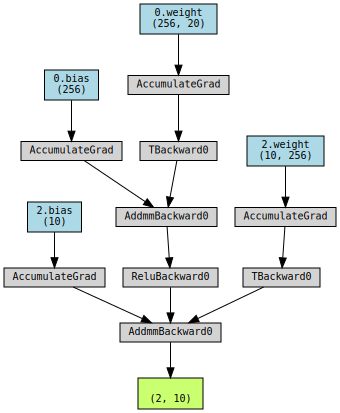

In [17]:
make_dot(y, params=dict(net.named_parameters()))

## 1.3 在`forward()`中执行代码
为了更自由地设置自己的架构，我们可不基于nn.netname去做，而是在代码中自定义

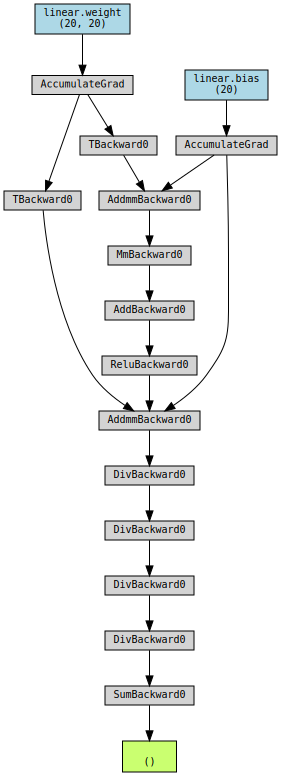

In [18]:
class FixedHiddenMLP(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.rand_weight = torch.rand((20, 20), requires_grad=False)
        self.linear = nn.Linear(in_features=20, out_features=20)
        
    def forward(self, X):
        X = self.linear(X)
        X = F.relu(input=torch.mm(X, self.rand_weight) + 1)
        X = self.linear(X)
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()
    
net = FixedHiddenMLP()
y = net(X)

make_dot(y, params=dict(net.named_parameters()))

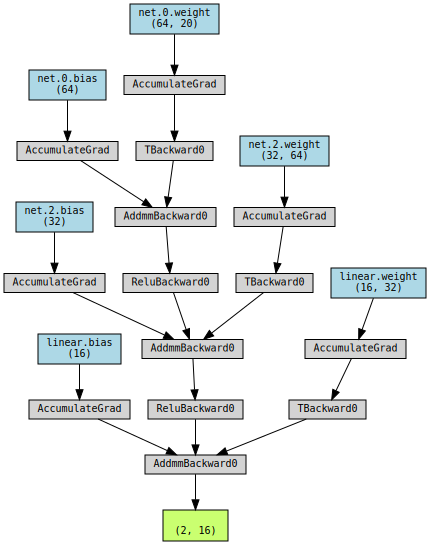

In [19]:
class NestMLP(nn.Module):
        
        def __init__(self):
            super().__init__()
            self.net = nn.Sequential(nn.Linear(in_features=20, out_features=64), nn.ReLU(), nn.Linear(in_features=64, out_features=32), nn.ReLU())
            self.linear = nn.Linear(in_features=32, out_features=16)
            
        def forward(self, X):
            return self.linear(self.net(X))
    
net = NestMLP()
y = net(X)
make_dot(y, params=dict(net.named_parameters()))

# 2.参数管理

既然模型都已经搭建好，为什么还需要参数管理？

这是因为有的时候我们需要提取参数用于复用，或者检查。

比较高级的场景可能会涉及复杂模型

我们关心的是：

1. 访问参数，调试以及可视化

2. 参数初始化

3. 不同模型组件共享参数

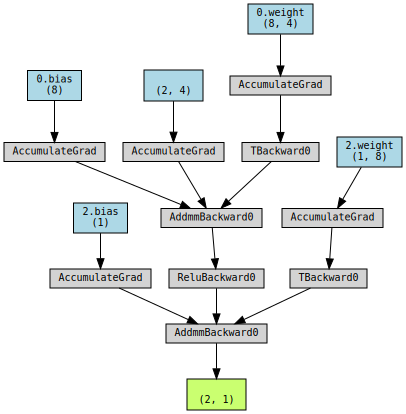

In [20]:
import torch
from torch import nn

net = nn.Sequential(nn.Linear(4,8), nn.ReLU(), nn.Linear(8,1))
X = torch.rand(size=(2,4), requires_grad=True)
y = net(X)

make_dot(y, params=dict(net.named_parameters()))

## 2.1 参数访问

In [21]:
net[2].state_dict()['weight'], net[2].state_dict()['bias']

(tensor([[ 0.1133, -0.1702,  0.1077, -0.2244,  0.0611, -0.2096, -0.1722,  0.1937]]),
 tensor([0.3258]))

In [22]:
print('type of net[2].weight:     ', type(net[2].weight))
print('shape of net[2].weight:    ', net[2].weight.shape)
print('just the output of net[2].weight\n', net[2].weight)
print('data of net[2].weight      ', net[2].weight.data)
print('grad of net[2].weight      ',net[2].weight.grad)

type of net[2].weight:      <class 'torch.nn.parameter.Parameter'>
shape of net[2].weight:     torch.Size([1, 8])
just the output of net[2].weight
 Parameter containing:
tensor([[ 0.1133, -0.1702,  0.1077, -0.2244,  0.0611, -0.2096, -0.1722,  0.1937]],
       requires_grad=True)
data of net[2].weight       tensor([[ 0.1133, -0.1702,  0.1077, -0.2244,  0.0611, -0.2096, -0.1722,  0.1937]])
grad of net[2].weight       None


In [23]:
print(*[(name, param.shape) for name, param in net[0].named_parameters()])
print(*[(name, param.shape) for name, param in net.named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))
('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


In [24]:
net.state_dict()['2.bias'].data

tensor([0.3258])

In [ ]:
def block1():
    return nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 4), nn.ReLU())  

def block2():
    net = nn.Sequential()
    for i in range(4):
        net.add_module(f'block{i}', module=block1())
    return net

rgnet = nn.Sequential(block2(), nn.Linear(4, 1))
y = rgnet(X)

make_dot(y, params=dict(rgnet.named_parameters()))

In [26]:
print(rgnet)

Sequential(
  (0): Sequential(
    (block0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


In [27]:
rgnet[0][1][0].weight.data

tensor([[-0.1050, -0.4029,  0.2993, -0.0772],
        [-0.0115,  0.0644,  0.4728, -0.1151],
        [-0.2202, -0.1341, -0.4629,  0.3947],
        [ 0.4841, -0.2683,  0.4747, -0.1000],
        [ 0.1989,  0.2166, -0.0734, -0.3104],
        [ 0.2958, -0.2534, -0.1806, -0.1818],
        [ 0.4343, -0.3260, -0.1056,  0.1823],
        [-0.0581, -0.0993,  0.4611, -0.3983]])

## 2.2 参数初始化

### 使用给定的初始方法

In [28]:
def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)
net.apply(init_constant)
net[0].weight.data

tensor([[ 0.7061,  0.5588,  0.1214,  0.1385],
        [-0.1804,  0.1799,  0.0983,  0.2303],
        [ 0.4636,  0.1245, -0.2359,  0.1936],
        [-0.5136, -0.2830,  0.4893,  0.4422],
        [ 0.2537, -0.2542, -0.6505, -0.3278],
        [ 0.3162,  0.4021, -0.5493,  0.0141],
        [ 0.2630, -0.5618,  0.3753,  0.6652],
        [-0.2454,  0.3059,  0.1427,  0.1773]])

### 使用自定义方法

In [29]:
def my_init(m):
    if type(m) == nn.Linear:
        print('Init', *[(name, param.shape) for name, param in m.named_parameters()])
        nn.init.uniform_(m.weight, -10, 10)
        m.weight.data *= m.weight.data.abs() >= 0.5
        
net.apply(my_init)
net[0].weight[:2]

Init ('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))
Init ('weight', torch.Size([1, 8])) ('bias', torch.Size([1]))


tensor([[-1.9973,  1.6849, -1.8369,  1.6956],
        [-8.0202, -0.0000,  4.7512, -6.5859]], grad_fn=<SliceBackward0>)

## 2.3 参数绑定

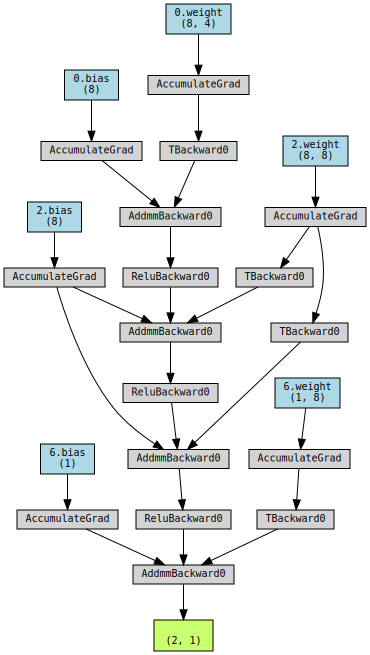

In [30]:
X = torch.rand(size=(2, 4))
shared = nn.Linear(8, 8)

net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.Linear(8, 1))
y = net(X)

make_dot(y, params=dict(net.named_parameters()))

In [32]:
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])


In [34]:
net[2].weight.data[0, 0] = 100
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])


# 3.延后初始化
模型一开始没有直接初始化，而是在输入后才初始化

# 4.自定义层

## 4.1 不带参数的层

In [49]:
from matplotlib.pyplot import cla
import torch
import torch.nn.functional as F
from torch import nn

class CenteredLayer(nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, X):
        return X - X.mean()

In [39]:
layer = CenteredLayer()
layer(torch.rand(1, 8))

tensor([[ 0.1853,  0.1424,  0.2886, -0.2967, -0.2096, -0.2553, -0.2186,  0.3639]])

In [44]:
net = nn.Sequential(nn.Linear(8, 128), CenteredLayer())
y = net(torch.rand(1, 8))
(y == 0).sum()

tensor(0)

## 4.2 带参数的层

In [45]:
class MyLinear(nn.Module):
    
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(data=torch.rand(in_features, out_features))
        self.bias = nn.Parameter(data=torch.rand(out_features))
        
    def forward(self, X):
        linear = torch.matmul(X, self.weight.data) + self.bias.data
        return F.relu(input=linear)

In [46]:
linear = MyLinear(5, 3)
linear.weight

Parameter containing:
tensor([[0.5095, 0.7873, 0.3116],
        [0.3356, 0.8312, 0.2035],
        [0.8049, 0.1610, 0.8599],
        [0.7505, 0.8530, 0.6687],
        [0.4629, 0.4041, 0.7835]], requires_grad=True)

In [47]:
linear(torch.rand(2, 5))

tensor([[1.5350, 1.9323, 2.1946],
        [2.2530, 2.6923, 2.9447]])

In [48]:
net = nn.Sequential(MyLinear(64, 8), MyLinear(8, 1))
net(torch.rand(2, 64))

tensor([[75.8330],
        [66.9408]])

# 5.读写文件

## 5.1加载和保存张量

In [66]:
import torch 
from torch import nn
from torch.nn import functional as F

In [72]:
x = torch.arange(4)
torch.save(x, 'x-file')
x2 = torch.load('x-file')
x2


tensor([0, 1, 2, 3])

In [73]:
y = torch.zeros(4)
torch.save([x, y], 'x-file')
x2, y2 = torch.load('x-file')
x2, y2

(tensor([0, 1, 2, 3]), tensor([0., 0., 0., 0.]))

In [74]:
mydict = {'x': x, 'y': y}
torch.save(mydict, 'mydict-file')
mydict2 = torch.load('mydict-file')
mydict2

{'x': tensor([0, 1, 2, 3]), 'y': tensor([0., 0., 0., 0.])}

## 5.1加载和保存模型参数

In [75]:
class MPL(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(20, 256)
        self.out = nn.Linear(256, 10)
        
    def forward(self, X):
        return self.out(F.relu(input=self.hidden(X)))

In [76]:
net = MPL()
X = torch.rand(2, 20)
Y = net(X)
Y

tensor([[-0.1204,  0.0909, -0.1724, -0.1808,  0.2580, -0.0790,  0.0495,  0.1489,
          0.0931,  0.0452],
        [-0.0659,  0.1238, -0.0968, -0.1478,  0.1644, -0.0294,  0.1101,  0.1775,
          0.0275, -0.0412]], grad_fn=<AddmmBackward0>)

In [77]:
torch.save(net.state_dict(), 'mlp.params')

In [79]:
clone = MPL()
clone.load_state_dict(torch.load('mlp.params'))
clone.eval()

MPL(
  (hidden): Linear(in_features=20, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)

# 6.GPU

In [80]:
!nvidia-smi

Sun Sep 10 22:40:55 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   48C    P8              18W / 140W |   1286MiB /  8192MiB |     18%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [81]:
torch.cuda.device_count()

1

In [86]:
x = torch.tensor([1, 2, 3], device=device)
x.device

device(type='cuda', index=0)

In [89]:
Z = x.cuda(0)
Z.device

device(type='cuda', index=0)

In [95]:
x = torch.ones(2, 3, device=device)
net = nn.Sequential(nn.Linear(3, 1))
net = net.to(device)
net(x)

tensor([[0.5162],
        [0.5162]], device='cuda:0', grad_fn=<AddmmBackward0>)